# MNIST Fashion classification with convolutional neural network

Study the Convolutionnal neural network (CNN) tutorial of Keras on the classification of the MNIST Fashion Dataset

Learning goals:
- Understand the model structure
- Evaluate and enhance the model
- Use several kinds of regularizers to improve the generalization (kernel/bias, dropout, dataset augmentation)

To compare with the [Dense (Perceptron) only implementation](../classification/ClassificationMultiMnistFashion.html) ([Notebook](../classification/ClassificationMultiMnistFashion.ipynb))

References:
1. [Introduction to CNNs - Tensorflow/Keras](https://www.tensorflow.org/beta/tutorials/images/intro_to_cnns)
2. [Keras Conv2D and Convolutional layer - PyImageSearch](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)
3. [Image preprocessing - Tensorflow/Keras](https://keras.io/preprocessing/image/)
4. [Keras ImageDataGenerator and Data Augmentation - PyImageSearch](https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/)
5. [Classify butterfly images with deep learning in Keras](https://towardsdatascience.com/classify-butterfly-images-with-deep-learning-in-keras-b3101fe0f98)
6. [Fashion MNIST with Keras and Deep Learning - PyImageSearch](https://www.pyimagesearch.com/2019/02/11/fashion-mnist-with-keras-and-deep-learning/)

In [35]:
# If using Plaidml to use hardware accelerators 
#import plaidml
#plaidml.keras.install_backend()

import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics as skMetrics
import tensorflow.keras.datasets.fashion_mnist as fashion_mnist

print('Keras version:', keras.__version__)

# Patch for macOS + Conda
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Keras version 2.2.4


## Data

Using the fashion MNIST dataset from https://github.com/zalandoresearch/fashion-mnist
It is made of 70k pictures classified in 10 categories. 
Images are greyscale, 28x28 pixels.

The train/test split is 60/10

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

image_width = 28
image_height = 28
image_nchannels = 1
n_classes = len(class_names)

batch_size = 128

In [4]:
train_images.shape

(60000, 28, 28)

Reshaping to get a tensor with the channels, and scaling the 8 bit pixels of the images to float values in [0,1)

In [5]:
train_images = train_images.reshape(60000, image_width, image_height, image_nchannels) / 255.0
test_images = test_images.reshape(10000, image_width, image_height, image_nchannels) / 255.0

## Helpers

In [6]:
def plot_history(hist, with_validation=False):
    """ Plot a classification history as outputted by Keras """
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(hist.history['loss'])
    if with_validation:
        plt.plot(hist.history['val_loss'])
        plt.legend(('train', 'valid'))
    plt.grid()
    plt.title('Loss')
    plt.subplot(1,3,2)
    plt.plot(hist.history['acc'])
    if with_validation:
        plt.plot(hist.history['val_acc'])
        plt.legend(('train', 'valid'))
    plt.grid()
    plt.title('Accuracy');

In [7]:
# Keras tuto helpers
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i].reshape(image_width, image_height)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [8]:
def plot_results(images, labels, predictions, num_rows=5, num_cols=3):
    """ Plot the first X test images, their predicted label, and the true label
        Color correct predictions in blue, incorrect predictions in red"""
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, 2*num_cols, 2*i+1)
      plot_image(i, predictions, labels, images)
      plt.subplot(num_rows, 2*num_cols, 2*i+2)
      plot_value_array(i, predictions, labels)
    plt.show() 

# 2D Convolutional neural network (CNN)

https://www.tensorflow.org/beta/tutorials/images/intro_to_cnns  __!! Tensorflow v2.0-beta tutorial__ but it works with TF v1.14, convergence is slower though

In [9]:
model1 = keras.models.Sequential([
    # Single image channel
    keras.layers.Conv2D(32, (3, 3), activation=keras.activations.relu, 
                        input_shape=(image_width, image_height, image_nchannels)), 
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation=keras.activations.relu),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dense(10, activation=keras.activations.softmax)
], 'model1')

model1.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model1.summary()

hist1 = model1.fit(train_images, train_labels, 
                   epochs=25, validation_split=0.2, batch_size=batch_size,
                   verbose=0)

W0819 21:34:23.479052 4660942272 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 21:34:23.506624 4660942272 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 21:34:23.509397 4660942272 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0819 21:34:23.521687 4660942272 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0819 21:34:23.566511 4660942272 deprecation_wrapper.py:119] From //ana

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

Final train accuracy: 0.974


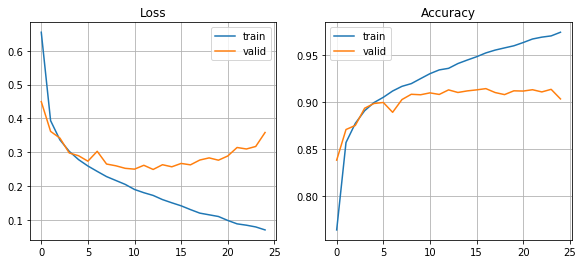

In [10]:
plot_history(hist1, True)
print('Final train accuracy: {:.3f}'.format(hist1.history['acc'][-1]))

In [11]:
test_loss1, test_acc1 = model1.evaluate(test_images, test_labels, verbose=0)
print('Test loss: {:.3f}, accuracy: {:.3f}'.format(test_loss1, test_acc1))

Test loss: 0.371, accuracy: 0.901


Here again there is a difference between the training and validation or test accuracies.

The result is quite lower compared to the referenced tutorial (claiming 99% test accuracy). Is this due to the use of Tensorflow 1.14 vs. 2.0-beta ?

As on the classical model, there is probably overfitting.

Here is the histogram of the ceofficients of the Dense layer of 64 neurons:

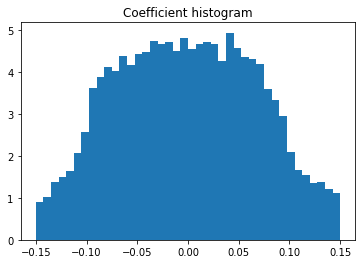

In [12]:
plt.hist(model1.get_weights()[6].reshape(-1), bins=40, range=(-0.15, 0.15), density=True);
plt.title('Coefficient histogram');

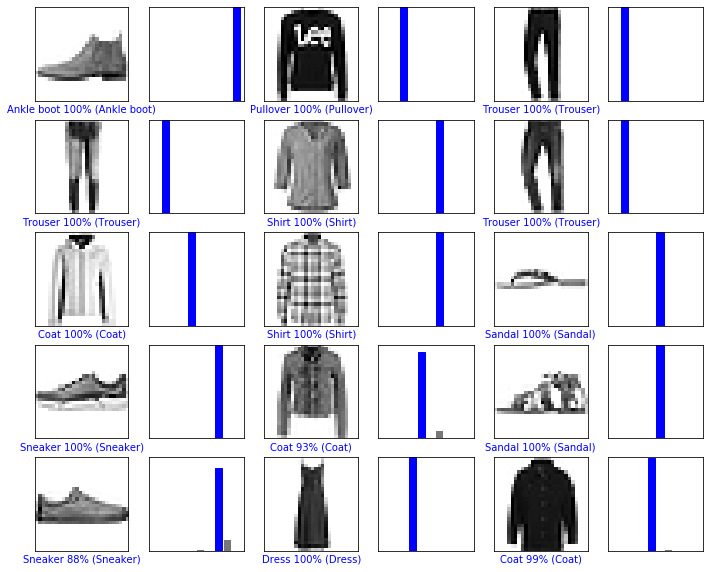

In [13]:
predictions1 = model1.predict(test_images[:20])
plot_results(test_images, test_labels, predictions1)

## CNN with regularizer

Let's apply a regularizer on the two largest layers, and decrease the size of the last Conv2D and the 1st Dense layers from 64 to 48.

In [14]:
model2 = keras.models.Sequential([
    # Single image channel
    keras.layers.Conv2D(32, (3, 3), activation=keras.activations.relu, 
                        input_shape=(image_width, image_height, image_nchannels)), 
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(48, (3, 3), activation=keras.activations.relu,
                        bias_regularizer=keras.regularizers.l1(0.00001),   # <---
                       kernel_regularizer=keras.regularizers.l1(0.00001)), # <---
    keras.layers.Flatten(),
    keras.layers.Dense(48, activation=keras.activations.relu,             # <---
                       bias_regularizer=keras.regularizers.l1(0.00001),    # <---
                       kernel_regularizer=keras.regularizers.l1(0.00001)), # <---
    keras.layers.Dense(10, activation=keras.activations.softmax)
], 'model2')

model2.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model2.summary()

hist2 = model2.fit(train_images, train_labels, 
                   epochs=24, validation_split=0.2, 
                   verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 48)          27696     
_________________________________________________________________
flatten_2 (Flatten)          (None, 432)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 48)                20784     
__________

Final train accuracy: 0.973


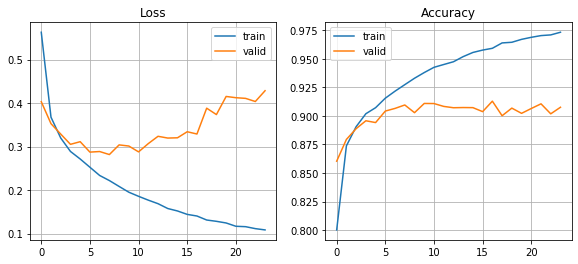

In [15]:
plot_history(hist2, True)
print('Final train accuracy: {:.3f}'.format(hist2.history['acc'][-1]))

In [16]:
test_loss2, test_acc2 = model2.evaluate(test_images, test_labels, verbose=0)
print('Test loss: {:.3f} accuracy: {:.3f}'.format(test_loss2, test_acc2))

Test loss: 0.456 accuracy: 0.905


Train accuracy is a little lower, test accuracy is the same as with the bigger model.

Coefficients are better spread on the layers with regularizers

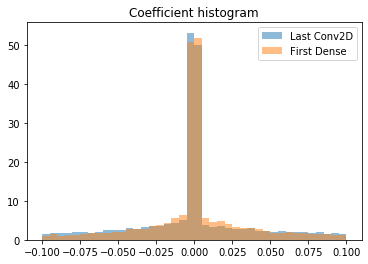

In [17]:
weights2 = model2.get_weights()
plt.hist(weights2[4].reshape(-1), bins=40, range=(-0.1, 0.1), density=True, alpha=0.5);
plt.hist(weights2[6].reshape(-1), bins=40, range=(-0.1, 0.1), density=True, alpha=0.5);
plt.legend(('Last Conv2D', 'First Dense'))
plt.title('Coefficient histogram');

## Using data augmentation

Data augmentation is increasing the size of a training dataset by adding some modified versions of the images, see [4] and [5] for a survey of available technics.

Below, we will use the inline technic through the preprocessor of Keras [3]

In [29]:
batch_size = 128
steps_per_epoch = len(train_images) // batch_size
n_epochs = 32

# Image preprocessor
data_gen3 = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=False) # All clothes and shoes are the same direction

# For validation data
data_gen3v = keras.preprocessing.image.ImageDataGenerator()

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
#data_gen3.fit(train_images)
#data_gen3v.fit(train_images)

# Clone model to reinit weights
model3 = keras.models.clone_model(model2)
model3.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# fits the model on batches with real-time data augmentation:
data_gen_flow3 = data_gen3.flow(train_images, train_labels, batch_size=batch_size)
data_gen_flow3v = data_gen3v.flow(train_images, train_labels, batch_size=batch_size)
hist3 = model3.fit_generator(data_gen_flow3, 
                    steps_per_epoch * 0.75, epochs=n_epochs, 
                    validation_data=data_gen_flow3v, validation_steps=steps_per_epoch * 0.25,
                    verbose=1)

Epoch 1/32
351/351 [==============================] - 15s 43ms/step - loss: 0.7746 - acc: 0.7170 - val_loss: 0.5286 - val_acc: 0.8083
Epoch 2/32
351/351 [==============================] - 14s 39ms/step - loss: 0.5140 - acc: 0.8144 - val_loss: 0.4366 - val_acc: 0.8500
Epoch 3/32
351/351 [==============================] - 14s 39ms/step - loss: 0.4542 - acc: 0.8386 - val_loss: 0.4067 - val_acc: 0.8560
Epoch 4/32
351/351 [==============================] - 14s 39ms/step - loss: 0.4178 - acc: 0.8521 - val_loss: 0.3751 - val_acc: 0.8735
Epoch 5/32
351/351 [==============================] - 14s 39ms/step - loss: 0.3946 - acc: 0.8619 - val_loss: 0.3347 - val_acc: 0.8854
Epoch 6/32
351/351 [==============================] - 14s 39ms/step - loss: 0.3778 - acc: 0.8687 - val_loss: 0.3397 - val_acc: 0.8809
Epoch 7/32
351/351 [==============================] - 14s 39ms/step - loss: 0.3604 - acc: 0.8735 - val_loss: 0.3054 - val_acc: 0.8923
Epoch 8/32
351/351 [==============================] - 14s 39ms

Final train accuracy: 0.921


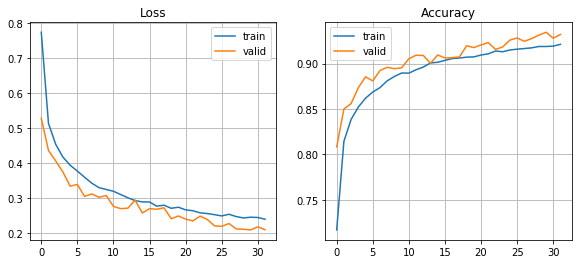

In [30]:
plot_history(hist3, True)
print('Final train accuracy: {:.3f}'.format(hist3.history['acc'][-1]))

In [31]:
test_loss3, test_acc3 = model3.evaluate(test_images, test_labels, verbose=0)
print('Test loss: {:.3f}, accuracy: {:.3f}'.format(test_loss3, test_acc3))

Test loss: 0.274, accuracy: 0.910


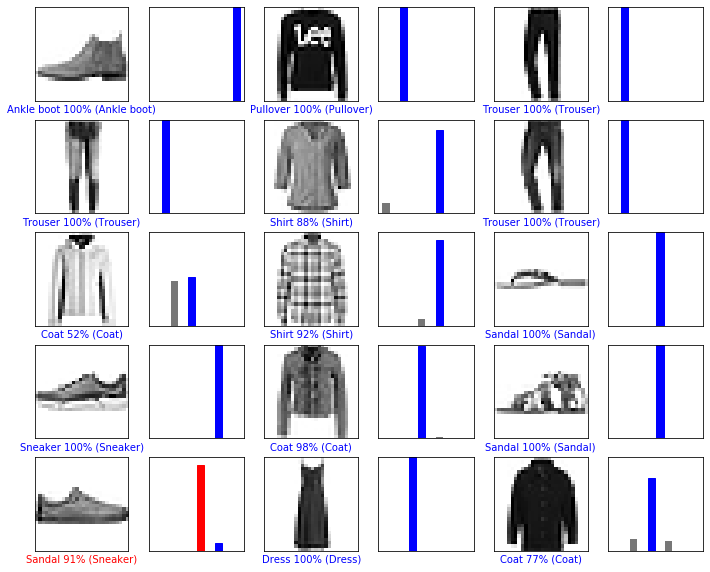

In [33]:
predictions3 = model3.predict(test_images)
plot_results(test_images, test_labels, predictions3)

In [34]:
print(skMetrics.classification_report(test_labels, predictions3.argmax(axis=1), target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.91      0.81      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.89      0.85      0.87      1000
       Dress       0.92      0.90      0.91      1000
        Coat       0.84      0.87      0.85      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.70      0.81      0.75      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

